In [1]:
import numpy as np
from polyphys.probe.prober import fsd
from polyphys.analyze import correlations
import MDAnalysis as mda
from MDAnalysis.analysis.base import AnalysisFromFunction
from MDAnalysis import transformations as mda_trans
from MDAnalysis.analysis import distances as mda_dist
import statsmodels.tsa.stattools as tsas

import imageio

from matplotlib.image import NonUniformImage
from matplotlib.patches import Circle, Rectangle
from matplotlib import cm

from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
def fit_exponential_decay(x, y):
    r"""Fit a function to an exponential decay

    .. math::  y = \exp\left(- \frac{x}{a}\right)

    Parameters
    ----------
    x, y : array_like
      The two arrays of data

    Returns
    -------
    a : float
      The coefficient *a* for this decay

    Notes
    -----
    This function assumes that data starts at 1.0 and decays to 0.0

    """
    def exp_func(x, a):
        return np.exp(-1*x/a)
    a = scipy.optimize.curve_fit(exp_func, x, y)[0][0]
    return a
def fit_exponential_growth(x, y):
    r"""Fit a function to an exponential decay

    .. math::  y = \exp\left(- \frac{x}{a}\right)

    Parameters
    ----------
    x, y : array_like
      The two arrays of data

    Returns
    -------
    a : float
      The coefficient *a* for this decay

    Notes
    -----
    This function assumes that data starts at 1.0 and decays to 0.0

    """
    def exp_func(x, a):
        return np.exp(x/a)
    a = scipy.optimize.curve_fit(exp_func, x, y)[0][0]
    return a

# Viz different properties for files

## nucleoid or bug files

In [ ]:
glob('/Users/amirhsi_mini/research_data/hns_cyl-trjs/*')
paths =  sorted(glob('/Users/amirhsi_mini/research_data/hns_cyl-trjs/N*'))
paths

In [ ]:
variables = sorted(np.unique([path.split('-')[-1] for path in paths]))
variables = variables[:-3]
variables

In [ ]:
for var in variables:
    print(var)
    if var not in ['distMatMonPatchT.npy', 'principalTMon.npy', 'stamps.csv']:
        dist_mon_hpatch_t = np.load('/Users/amirhsi_mini/research_data/hns_cyl-trjs/N200kbmm2r4.5nh4ac2lz75nc221ens1.ring-nucleoid-'+var)
        plt.plot(dist_mon_hpatch_t)
        if var not in ['bondCosineCorrVecMon.npy', 'loopLengthMonHist.npy']:
            plt.axhline(np.mean(dist_mon_hpatch_t), c='red')
        plt.savefig('N200kbmm2r4.5nh4ac2lz75nc221ens1.ring-' + var[:-3]+'pdf')
        plt.close()

In [ ]:
gyr_t = np.load('/Users/amirhsi_mini/research_data/hns_cyl-trjs/N200kbmm2r4.5nh12ac2lz75nc552ens4.ring-nucleoid-gyrTMon.npy')
time = 5000 * np.arange(0,len(gyr_t))
fsd_t = np.load('/Users/amirhsi_mini/research_data/hns_cyl-trjs/N200kbmm2r4.5nh12ac2lz75nc552ens4.ring-nucleoid-fsdTMon.npy')
asphere = np.load('/Users/amirhsi_mini/research_data/hns_cyl-trjs/N200kbmm2r4.5nh12ac2lz75nc552ens4.ring-nucleoid-asphericityTMon.npy')
shape_t = np.load('/Users/amirhsi_mini/research_data/hns_cyl-trjs/N200kbmm2r4.5nh12ac2lz75nc552ens4.ring-nucleoid-shapeTMon.npy')
trans_size_t = np.load('/Users/amirhsi_mini/research_data/hns_cyl-trjs/N200kbmm2r4.5nh12ac2lz75nc552ens4.ring-nucleoid-transSizeTMon.npy')

In [ ]:
color_palette = 'tab10'
plot_context = 'paper'
font_scale = 1.5
height = 6
aspect = 1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(aspect*height, height), sharex=True)
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
slicer = 0
ax = axes[0]
ax.plot(time, gyr_t)
gyr_mean = np.mean(gyr_t[slicer:])
ax.axhline(y=gyr_mean, c='red', label=fr'$\langle R_g\rangle={round(gyr_mean, 3)}$')
ax.axvline(x=time[slicer], c='gray',ls='--', label=fr'$t/\tau_{{LJ}}={time[slicer]}$')
ax.set_ylabel(r'$R_g(t)$')
ax.set_title(r'Cylindrical confinement: $N=200, D/a_m=8, a_c/a_m=2, \phi_c=0.4, n_{{hns}}=12$')
ax.legend(ncols=2)

ax = axes[1]
ax.plot(time, fsd_t)
fsd_mean = np.mean(fsd_t[slicer:])
ax.axhline(y=fsd_mean, c='red', label=fr'$\langle L\rangle={np.format_float_positional(fsd_mean,precision=3)}$')
ax.axvline(x=time[slicer], c='gray',ls='--', label=fr'$t/\tau_{{LJ}}={time[slicer]}$')
ax.set_ylabel(r'$L$')
ax.set_xlabel(r'$t/\tau_{LJ}$')
ax.legend(ncols=2)

ax = axes[2]
ax.plot(time, trans_size_t)
fsd_mean = np.mean(trans_size_t[slicer:])
ax.axhline(y=fsd_mean, c='red', label=fr'$\langle R_{{\perp}}\rangle={round(fsd_mean,3)}$')
ax.axvline(x=time[slicer], c='gray',ls='--', label=fr'$t/\tau_{{LJ}}={time[slicer]}$')
ax.set_ylabel(r'$R_{\perp}$')
ax.set_xlabel(r'$t/\tau_{LJ}$')
ax.legend(ncols=2)

ax = axes[3]
ax.plot(time, asphere)
fsd_mean = np.mean(asphere[slicer:])
ax.axhline(y=fsd_mean, c='red', label=fr'$\langle \Delta\rangle={round(fsd_mean,3)}$')
ax.axvline(x=time[slicer], c='gray',ls='--', label=fr'$t/\tau_{{LJ}}={time[slicer]}$')
ax.set_ylabel(r'$\Delta$')
ax.set_xlabel(r'$t/\tau_{LJ}$')
ax.legend(ncols=2)

ax = axes[4]
ax.plot(time, shape_t)
fsd_mean = np.mean(shape_t[slicer:])
ax.axhline(y=fsd_mean, c='red', label=fr'$\langle S\rangle={round(fsd_mean,3)}$')
ax.axvline(x=time[slicer], c='gray',ls='--', label=fr'$t/\tau_{{LJ}}={time[slicer]}$')
ax.set_ylabel(r'$S$')
ax.set_xlabel(r'$t/\tau_{LJ}$')
ax.legend(ncols=2)

plt.show()
fig.savefig('chainsize.pdf')

In [ ]:
bond_lengths = np.load('/Users/amirhsi_mini/research_data/hns_cyl-trjs/N200kbmm2r4.5nh12ac2lz75nc552ens4.ring-nucleoid-bondLengthVecMon.npy')
cosine_corrs = np.load('/Users/amirhsi_mini/research_data/hns_cyl-trjs/N200kbmm2r4.5nh12ac2lz75nc552ens4.ring-nucleoid-bondCosineCorrVecMon.npy')

#trj_cosine_corrs = np.mean(trj_cosine_corrs_mean,axis=0)
mean_bond = np.mean(bond_lengths[0])
print('bond length: ', mean_bond)
bond_lags = np.arange(1, len(cosine_corrs)+1)
per_to_bond = fit_exponential_decay(
    bond_lags,
    cosine_corrs
)
print('persisten to bond ratio', per_to_bond)

In [ ]:
color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'paper'
font_scale = 1.5
height = 4
aspect = 1.5*1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    #'ncol': 1,
    #'bbox_to_anchor': (1., 0.95),
    'frameon': False,
    #'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1
}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(aspect*height, height))
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)

ax.scatter(bond_lags,cosine_corrs,c='green',marker='o',s=10,alpha=0.7)
ax.plot(bond_lags,np.exp(-(bond_lags-1)/per_to_bond),color='red',label=fr'$\exp[-j/(l_p/l_b)]$ with $l_p/l_b={round(per_to_bond,3)}$ (fitted to $20$ closest bonds)')
#short_mean = np.mean(long[55000:,1])
ax.axhline(y=0,c='black', lw=0.75)
#ax.axvline(x=0.005*long[55000,0],c='gray',ls='--',label='Equilibrium reached!')
ax.legend()
#ax.set_ylabel(r'$R_g(t)$')
ax.set_xlabel('Bond index lag, j')
#bond_grid.set_ylabels(r'$\langle\cos(\theta_{i,i+j})\rangle$')
ax.set_ylabel(r'$C(j)=\langle\hat{l}_i.\hat{l}_{i+j}\rangle$')
#ax.text(120, 0.7, fr'fit to first $25$ bonds')
ax.set_title(r'Cylindrical confinement: $N=200, D/a_m=8, a_c/a_m=2, \phi_c=0.4, n_{{hns}}=12$')
plt.show()
fig.savefig('bond_correlations.pdf')

In [ ]:
# confined
gyr1 = np.loadtxt('/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1r8lz675nc0ens1.ring/N1000kbmm24nh0ac1r8lz675nc0ens1.ring.gyrTDna.txt')
# free
gyr2 = np.loadtxt('/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1l250nc0ens1.ring/N1000kbmm24nh0ac1l250nc0ens1.ring.gyrTDna.txt')
#gyr1 = np.loadtxt('./N1000dt0.005ndump2000adump5000kbmm25r7.5lz600nh0ac1nc0ens1.gyrTDna.txt')
#gyr2 = np.loadtxt('./N1000epshm29kbmm25nh0ac1nc0l500dt0.005ndump2000adump5000ens1.gyrTDna.1.txt')

In [ ]:
color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
plot_context = 'paper'
font_scale = 1.5
height = 5
aspect = 1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}

fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(aspect*height, height), sharex=True)
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
slice_id = 1000
ax.plot(0.005*gyr1[:,0],gyr1[:,1])
gyr1_mean = np.mean(gyr1[slice_id:,1])
ax.set_title(r'Cylindrical confinement: $N=1000, D/a_m=15, \phi_c=0, n_{{hns}}=0$')
ax.axhline(y=gyr1_mean,c='red',label=fr'$\langle R_g\rangle={round(gyr1_mean,3)}$')
#ax.axvline(x=0.005*gyr1[slice_id,0],c='gray',ls='--',label=fr'$t/\tau_{{LJ}}={0.005*gyr1[slice_id,0]}$')
ax.legend()

ax.plot(0.005*gyr2[:,0],gyr2[:,1])
slice_id = 1000
gyr2_mean = np.mean(gyr2[slice_id:,1])
ax.set_title(r'Free space: $N=1000, \phi_c=0, n_{{hns}}=0$')
ax.axhline(y=gyr2_mean,c='red',label=fr'$\langle R_g\rangle={round(gyr2_mean,3)}$')
#ax.axvline(x=0.005*gyr2[slice_id,0],c='gray',ls='--',label=fr'$t/\tau_{{LJ}}={0.005*gyr2[slice_id,0]}$')
ax.legend()
fig.tight_layout()
plt.show()

##  all files

In [94]:
paths = sorted(glob('/Users/amirhsi_mini/research_data/HnsCyl-probe/*'))
paths

['/Users/amirhsi_mini/research_data/HnsCyl-probe/N200D8nh12ac2',
 '/Users/amirhsi_mini/research_data/HnsCyl-probe/N200D8nh30ac2',
 '/Users/amirhsi_mini/research_data/HnsCyl-probe/N200D8nh4ac2',
 '/Users/amirhsi_mini/research_data/HnsCyl-probe/N200kbmm2r4.5nh0ac1lz75nc5760ens4-all-xEdge.npy',
 '/Users/amirhsi_mini/research_data/HnsCyl-probe/N200kbmm2r4.5nh0ac1lz75nc5760ens4-all-xyHistCrd.npy',
 '/Users/amirhsi_mini/research_data/HnsCyl-probe/N200kbmm2r4.5nh0ac1lz75nc5760ens4-all-xyHistHns.npy',
 '/Users/amirhsi_mini/research_data/HnsCyl-probe/N200kbmm2r4.5nh0ac1lz75nc5760ens4-all-xyHistMon.npy',
 '/Users/amirhsi_mini/research_data/HnsCyl-probe/N200kbmm2r4.5nh0ac1lz75nc5760ens4-all-yEdge.npy',
 '/Users/amirhsi_mini/research_data/HnsCyl-probe/N200kbmm2r4.5nh0ac2lz75nc111ens1.j01.ring-all',
 '/Users/amirhsi_mini/research_data/HnsCyl-probe/N200kbmm2r4.5nh30ac1lz75nc5760ens4-all-rEdgeCrd.npy',
 '/Users/amirhsi_mini/research_data/HnsCyl-probe/N200kbmm2r4.5nh30ac1lz75nc5760ens4-all-rEdgeHns.np

In [95]:
variables = sorted(np.unique([path.split('-')[-1] for path in paths]))
print(variables)
hist_variables = [var for var in variables if 'Hist' in var]
print(hist_variables)
phi_variables = [var for var in variables if 'Phi' in var]
print(phi_variables)
edge_variables = [var for var in variables if 'Edge' in var]
edge_variables

['all', 'probe/N200D8nh12ac2', 'probe/N200D8nh30ac2', 'probe/N200D8nh4ac2', 'rEdgeCrd.npy', 'rEdgeHns.npy', 'rEdgeMon.npy', 'rHistCrd.npy', 'rHistHns.npy', 'rHistMon.npy', 'rPhiCrd.npy', 'rPhiHns.npy', 'rPhiMon.npy', 'xEdge.npy', 'xyHistCrd.npy', 'xyHistHns.npy', 'xyHistMon.npy', 'yEdge.npy']
['rHistCrd.npy', 'rHistHns.npy', 'rHistMon.npy', 'xyHistCrd.npy', 'xyHistHns.npy', 'xyHistMon.npy']
['rPhiCrd.npy', 'rPhiHns.npy', 'rPhiMon.npy']


['rEdgeCrd.npy', 'rEdgeHns.npy', 'rEdgeMon.npy', 'xEdge.npy', 'yEdge.npy']

In [ ]:
for var in hist_variables:
    if var.startswith('xyHist'):
        print(var)
        dist_mon_hpatch_t = np.load('/Users/amirhsi_mini/research_data/HnsCyl-probe/N200kbmm2r4.5nh0ac1lz75nc5760ens4--all-'+var)
        print(dist_mon_hpatch_t)
        plt.plot(dist_mon_hpatch_t)
        plt.savefig('N200kbmm2r4.5nh0ac2lz75nc111ens1.j01.ring-' + var[:-3]+'pdf')
        plt.close()

In [78]:
hist_variables

['xyHistCrd.npy', 'xyHistHns.npy', 'xyHistMon.npy']

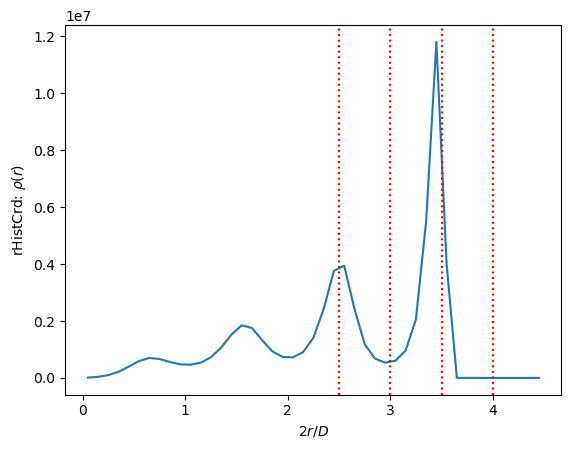

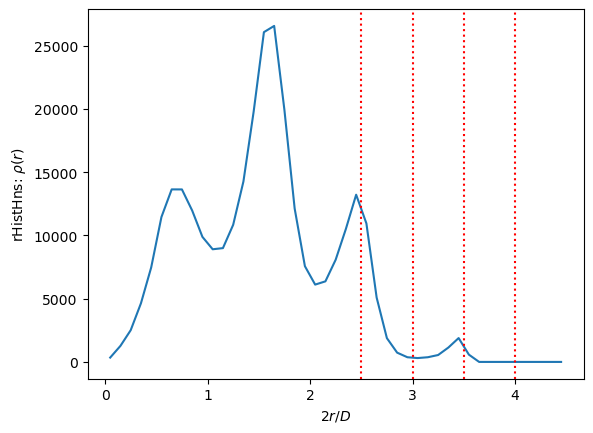

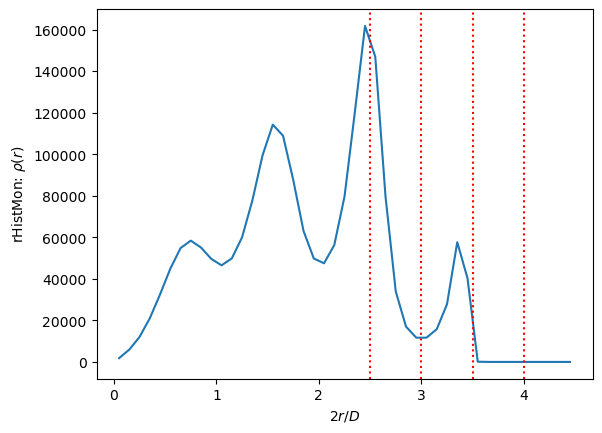

In [98]:
filename = 'N200kbmm2r4.5nh30ac1lz75nc5760ens4'
#
filename = 'N200kbmm2r4.5nh30ac2lz75nc552ens4'
for var in hist_variables:
    if var.startswith('rHist'):
        fig, ax = plt.subplots()
        dist_mon_hpatch_t = np.load('/Users/amirhsi_mini/research_data/HnsCyl-probe/'+filename+'-all-'+var)
        redges = np.load('/Users/amirhsi_mini/research_data/HnsCyl-probe/'+filename+'-all-'+var[0]+'Edge'+ var[-7:])
        rcenters = (redges[:-1] + redges[1:]) / 2
        ax.plot(rcenters, dist_mon_hpatch_t)
        ax.axvline(4, c='red',ls=':')
        ax.axvline(3.5, c='red',ls=':')
        ax.axvline(3, c='red',ls=':')
        ax.axvline(2.5, c='red',ls=':')
        ax.set_xlabel(r"$2r/D$")
        ax.set_ylabel(var[:-4] + r": $\rho(r)$")
        plt.savefig(filename +'-'+ var[:-3]+'pdf')
        plt.show()

9.0


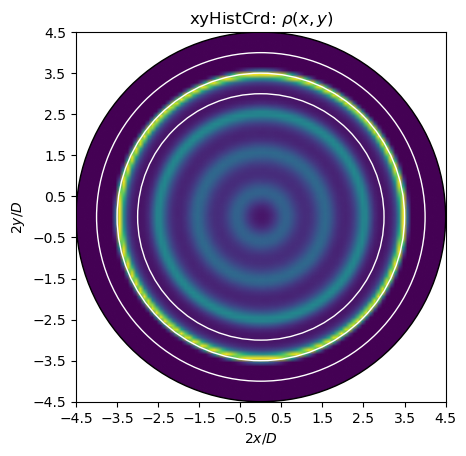

9.0


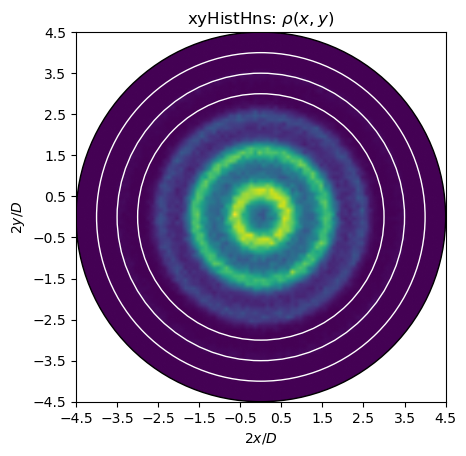

9.0


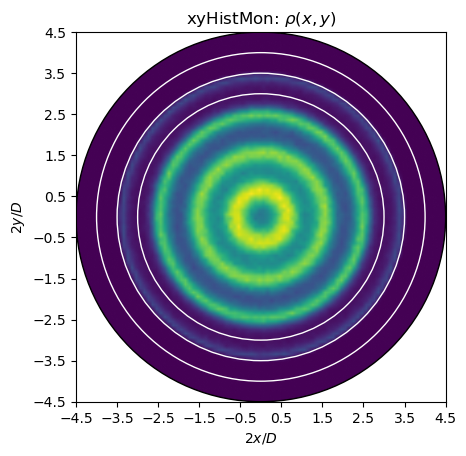

In [74]:
interp = 'bilinear'
filename = 'N200kbmm2r4.5nh30ac1lz75nc5760ens4'
#filename = 'N200kbmm2r4.5nh30ac2lz75nc552ens4'
for var in hist_variables:
    if var.startswith('xyHist'):
        fig, ax = plt.subplots()
        dist_mon_hpatch_t = np.load('/Users/amirhsi_mini/research_data/HnsCyl-probe/'+filename+'-all-'+var)
        xedges = np.load('/Users/amirhsi_mini/research_data/HnsCyl-probe/'+filename+'-all-'+var[0]+'Edge.npy')
        print(np.ptp(xedges))
        xcenters = (xedges[:-1] + xedges[1:]) / 2
        yedges = np.load('/Users/amirhsi_mini/research_data/HnsCyl-probe/'+filename+'-all-'+var[1]+'Edge.npy')
        ycenters = (yedges[:-1] + yedges[1:]) / 2
        circle = Circle((0, 0), 4.5, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
        ax.add_patch(circle)
        for r in [3, 3.5, 4]:
            circle2 = Circle((0, 0), r, facecolor='none',
                        edgecolor='white', linewidth=1, alpha=1, zorder=1)
            ax.add_patch(circle2)
        im = NonUniformImage(ax, interpolation=interp, extent=(-1, 1, -1, 1))
        im.set_data(xcenters, ycenters, dist_mon_hpatch_t)
        im.set(clip_path=circle, clip_on=True)
        ax.add_image(im)
        #ax.axvline(x=3.5,ymin=0.25,ymax=0.75)
        #ax.axvline(x=-3.5,ymin=0.25,ymax=0.75)
        ax.set_box_aspect(1)
        #ax.set_xlim(-1.05, 1.05)
        ax.set_xticks(np.arange(-4.5,4.75,1))
        #ax.set_ylim(-1.05, 1.05)
        ax.set_yticks(np.arange(-4.5,4.75,1))
        ax.set_xlabel(r"$2x/D$")
        ax.set_ylabel(r"$2y/D$")
        ax.set_title(var[:-4] + r": $\rho(x,y)$")
        plt.savefig(filename +'-'+ var[:-3]+'pdf')
        plt.show()

# Test measurements:

In [ ]:
# free
sorted(glob('../../Datasets/N200kbmm2r4.5nh12ac2lz75nc552ens2.ring/N*'))


In [ ]:
%%time
topo = '../../Datasets/N200kbmm2r4.5nh12ac2lz75nc552ens2.ring/N200kbmm2r4.5nh12ac2lz75nc552ens2.ring.nucleoid.data'
traj = ['../../Datasets/N200kbmm2r4.5nh12ac2lz75nc552ens2.ring/N200kbmm2r4.5nh12ac2lz75nc552ens2.ring.nucleoid.lammpstrj']
## 14 min for 2 trjs
## 9 min for N=200 no crowd no hns with all transformations, ndump=2000
## 9 min for N=200 no crowd no hns no need for all transformations, ndump=5000
for i, trj in enumerate(traj):
    cell = mda.Universe(
        topo,
        trj,
        topology_format='DATA',
        format='LAMMPSDUMP',
        lammps_coordinate_convention='unscaled',
        unwrap_images=False,
        atom_style="id resid type x y z", 
        dt=5000*0.005
    )
    if i == 0:
        sliced_trj = cell.trajectory[:10]
    else:
        sliced_trj = cell.trajectory
    n_frames = len(sliced_trj)
    bug = cell.select_atoms('resid 1')  # the bug
    #workflow = [
    #    mda_trans.unwrap(cell.atoms),
    #    mda_trans.center_in_box(bug),
    #    mda_trans.wrap(cell.atoms)
    #]
    #cell.trajectory.add_transformations(*workflow)
    # selecting atom groups:
    bug = cell.select_atoms('resid 1')  # the bug
    hns_patch = cell.select_atoms('type 2')  # the hns patches
    hns_core = cell.select_atoms('type 3')  # the hns patches
    # defining collectors
    # bug:
    gyr_t = []
    fsd_t = []
    trans_size_t = []
    principal_axes_t = []
    asphericity_t = []
    shape_parameter_t = []
    # - bond info
    n_bonds = len(bug.bonds.indices)
    bond_lengths = np.zeros((n_bonds, 1), dtype=np.float64)
    cosine_corrs = np.zeros(n_bonds, dtype=np.float64)
    # distance matrices
    dist_m_hpatch_t = []
    # dist_m_hcore_t = []
    # dist_m_m_t = []
    for _ in sliced_trj:
        # bug:
        # various measures of chain size
        gyr_t.append(bug.radius_of_gyration())
        fsd_t.append(fsd(bug.positions))
        # shape parameters:
        asphericity_t.append(bug.asphericity(wrap=False, unwrap=False))
        shape_parameter_t.append(bug.shape_parameter(wrap=False))
        principal_axes_t.append(bug.principal_axes(wrap=False))
        # bond info
        bond_dummy, cosine_dummy = correlations.bond_info(
            bug,
            'ring'
            )
        bond_lengths += bond_dummy
        cosine_corrs += cosine_dummy
        # bug - hns patch:
        # distance matrices
        dummy = mda_dist.distance_array(bug, hns_patch)#, box=cell.dimensions)
        dist_m_hpatch_t.append(dummy)
        # dummy = mda_dist.distance_array(bug, hns_core, box=cell.dimensions)
        # dist_m_hcore_t.append(dummy)
        # dummy = mda_dist.distance_array(bug, bug, box=cell.dimensions)
        # dist_m_m_t.append(dummy)
    # Saving collectors to memory
    # bug
    # Simulation stamps:
    # bond info
    bond_lengths = bond_lengths / n_frames
    bonds_per_lag = np.arange(n_bonds, 0, -1)
    cosine_corrs = cosine_corrs / (n_frames * bonds_per_lag)
    bond_lengths = bond_lengths.reshape(n_bonds,)
    print('done.')

In [ ]:
dist_mat_foci = np.zeros((hns_patch.n_atoms, hns_patch.n_atoms))
dist_array = mda_dist.self_distance_array(hns_patch)
k=0
for i in range(hns_patch.n_atoms):
    for j in range(i + 1, hns_patch.n_atoms):
        dist_mat_foci[i, j] = dist_array[k]
        k += 1

In [ ]:
mat_m_hpatch = np.array(
    [[1, 0, 1, 0, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 1, 0],
     [1, 0, 0, 0, 0, 0, 1, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 1],
     [0, 1, 0, 1, 0, 1, 0, 0],
     [0, 1, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0]],
    dtype=int
)
print(" ", np.arange(1,9))
print(mat_m_hpatch)
print(np.arange(1,11))
print(mat_m_hpatch.T)
print()
mat_m_m = np.matmul(mat_m_hpatch,mat_m_hpatch.T)
print(mat_m_m)

In [ ]:
_, n_cols = mat_m_hpatch.shape  # shape: n_atoms * n_atoms
contact_matrix = mat_m_hpatch.copy()
# Loop over all pairs of column indices
for i, j in itertools.combinations(range(n_cols), 2):
    # Check if columns i and j have any common nonzero elements
    if np.any(contact_matrix[:, i] & contact_matrix[:, j]):
        # If so, set all nonzero elements in columns i and j to 1
        transient = contact_matrix[:, i] | contact_matrix[:, j]
        contact_matrix[:, i] = transient
        contact_matrix[:, j] = transient

contact_matrix

In [ ]:
mat_m_hcore = np.zeros((mat_m_hpatch.shape[0], mat_m_hpatch.shape[1]//2))
print(mat_m_hcore)
for i in range(n_cols//2):
    print(2*i)
    print(2*i+1)
    mat_m_hcore[:,i] = contact_matrix[:, 2*i] | contact_matrix[:, 2*i+1]

In [ ]:
mat_m_hcore

In [ ]:
import itertools
for i, j in itertools.product(range(5), range(4)):
    print(i,j)
print()
for i, j in itertools.combinations(range(5),2):
    print(i,j)

In [ ]:
mda_dist.self_distance_array(hns_patch)#, box=cell.dimensions)

In [ ]:
print(cell)
print(hasattr(cell, 'trajectory'))
print(len(cell.trajectory))
print(cell.atoms)
print(cell.residues)
print('bug')
print(bug.n_residues)
print(bug.residues)
print(bug.atoms.indices)
print(bug.positions)
print(bug.bonds.indices)
print('hns_patch')
print(hns_patch.n_residues)
print(hns_patch.residues)
print(hns_patch.atoms)
print('hns_core')
print(hns_core.n_residues)

# Viz different properties:

## Radius of gyration and farthermost distance plot

In [ ]:
color_palette = 'tab10'
plot_context = 'paper'
font_scale = 1.5
height = 5
aspect = 1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(aspect*height, height), sharex=True)
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
slicer = 0
ax = axes
ax.plot(time, gyr_t)
short_mean = np.mean(gyr_t[slicer:])
ax.axhline(y=short_mean,c='red',label=fr'$\langle R_g\rangle={round(short_mean,3)}$')
#ax.axvline(x=time[slicer],c='gray',ls='--',label=fr'$t/\tau_{{LJ}}={time[slicer]}$')
ax.legend(loc='lower right')
ax.set_ylabel(r'$R_g(t)$')
ax.set_title(r'Cylindrical confinement: $N=1000, D/a_m=15, a_c/a_m=1, \phi_c=0, n_{{hns}}=0$')
#ax = axes[1]
#fsd_mean = np.mean(fsd_t[slicer:])
#ax.plot(time, fsd_t)
#ax.axhline(y=fsd_mean,c='red',label=fr'$\langle L\rangle={round(fsd_mean,3)}$')
#ax.axvline(x=time[slicer],c='gray',ls='--',label=fr'$t/\tau_{{LJ}}={time[slicer]}$')
#ax.set_ylabel(r'$L$')
#ax.legend(loc='lower right')
ax.set_xlabel(r'$t/\tau_{LJ}$')
plt.show()
fig.savefig('chainsize.pdf')

## Persistance length

In [ ]:
#trj_cosine_corrs = np.mean(trj_cosine_corrs_mean,axis=0)
mean_bond = np.mean(trj_bond_lengths_mean[0])
print('bond length: ', mean_bond)
bond_lags = np.arange(1, n_bonds+1)
per_to_bond = fit_exponential_decay(
    bond_lags[:],
    trj_cosine_corrs_mean[0][:]
)
print('persisten to bond ratio', per_to_bond)
print('persisten length', per_to_bond*mean_bond)
print('persisten length in nm', per_to_bond*mean_bond*2.5)

In [ ]:
color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'paper'
font_scale = 1.5
height = 4
aspect = 1.5*1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    #'ncol': 1,
    #'bbox_to_anchor': (1., 0.95),
    'frameon': False,
    #'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1
}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(aspect*height, height))
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)

ax.scatter(bond_lags,trj_cosine_corrs_mean[0],c='green',marker='o',s=10,alpha=0.7)
ax.plot(bond_lags,np.exp(-(bond_lags-1)/per_to_bond),color='red',label=fr'$\exp[-j/(l_p/l_b)]$ with $l_p/l_b={round(per_to_bond,3)}$')# (fitted to $75$ closest bonds)')
#short_mean = np.mean(long[55000:,1])
ax.axhline(y=0,c='black', lw=0.75)
#ax.axvline(x=0.005*long[55000,0],c='gray',ls='--',label='Equilibrium reached!')
ax.legend()
#ax.set_ylabel(r'$R_g(t)$')
ax.set_xlabel('Bond index lag, j')
#bond_grid.set_ylabels(r'$\langle\cos(\theta_{i,i+j})\rangle$')
ax.set_ylabel(r'$C(j)=\langle\hat{l}_i.\hat{l}_{i+j}\rangle$')
#ax.text(120, 0.7, fr'fit to first $25$ bonds')
ax.set_title(r'Cylindrical confinement: $N=200, D/a_m=15, a_c/a_m=1, \phi_c=0, n_{{hns}}=0$')
plt.show()
fig.savefig('bond_correlations.pdf')

### Non-linear fit

In [ ]:
def fit_exponential_non_linear_decay(x, y):
    r"""Fit a function to an exponential decay

    .. math::  y = \exp\left(- \frac{x}{a}\right)

    Parameters
    ----------
    x, y : array_like
      The two arrays of data

    Returns
    -------
    a : float
      The coefficient *a* for this decay

    Notes
    -----
    This function assumes that data starts at 1.0 and decays to 0.0

    """
    def exp_func(x, a, exponent):
        return np.exp(-1*x**exponent/a)
    a, exponent = scipy.optimize.curve_fit(exp_func, x, y)[0]
    return a, exponent

In [ ]:
gyr = np.concatenate((gyr1,gyr2),axis=0)
gyr.shape

In [ ]:
plot_context = 'paper'
font_scale = 2
height = 6
aspect = 1.618
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(aspect*height, height), sharex=True)
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)



gyr=gyr_t
acf_t = tsas.acf(
            gyr,
            nlags=30000,
            alpha=0.05,
        )
acf = acf_t[0]
acf_lag = np.arange(1,len(acf)+1)
lower_cl = acf_t[1][:, 0] - acf_t[0]
upper_cl = acf_t[1][:, 1] - acf_t[0]
decay_time = fit_exponential_decay(
    acf_lag,
    acf
)
ax = axes
ax.plot(acf_lag, acf)
#ax.plot(acf_lag,np.exp(-1*acf_lag**decay_time[1]/decay_time[0]))
ax.plot(acf_lag,np.exp(-1*acf_lag/decay_time),label=fr'$\exp[-t/\tau]$ with $\tau={round(decay_time,3)}$')
ax.axhline(y=0,c='black', lw=0.75)
ax.fill_between(
            acf_lag,
            lower_cl,
            upper_cl,
            color='green',
            alpha=0.25,
            label=r'CI ($\alpha=0.05$)'
        )
ax.legend(ncols=2)
ax.set_title(r'Free space: $N=1000, D/a_m=15, a_c/a_m=1, \phi_c=0, n_{{hns}}=0$')
#ax.set_xlabel(r'Time lag, $t^{\prime}$')
ax.set_ylabel(r'$C_{R_g}(t^{\prime})$')


acf_t = tsas.acf(
            fsd_t,
            nlags=30000,
            alpha=0.05,
        )
acf = acf_t[0]
acf_lag = np.arange(1,len(acf)+1)
lower_cl = acf_t[1][:, 0] - acf_t[0]
upper_cl = acf_t[1][:, 1] - acf_t[0]
decay_time = fit_exponential_decay(
    acf_lag,
    acf
)
ax = axes[1]
ax.plot(acf_lag, acf)
ax.plot(acf_lag,np.exp(-1*acf_lag**decay_time[1]/decay_time[0]))
ax.plot(acf_lag,np.exp(-1*acf_lag/decay_time),label=fr'$\exp[-t/\tau]$ with $\tau={round(decay_time,3)}$')
ax.fill_between(
            acf_lag,
            lower_cl,
            upper_cl,
            color='green',
            alpha=0.25,
            label=r'CI ($\alpha=0.05$)'
        )
ax.legend(ncols=2)
ax.axhline(y=0,c='black', lw=0.75)
ax.set_xlabel(r'Time lag, $t$')
ax.set_ylabel(r'$C_{L}(t^{\prime})$')
fig.tight_layout()
fig.savefig('acf.pdf')
plt.show()

# Gyr and persistance length

In [ ]:
gyr=gyr_t

In [ ]:
plot_context = 'paper'
font_scale = 1.5
height = 5
aspect = 1.618
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(aspect*height, height))
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)

ax = axes[0]
idx_slice = 0
ax.plot(time,gyr)
short_mean = np.mean(gyr[idx_slice:])
ax.axhline(y=short_mean,c='red',label=fr'$\langle R_g\rangle={round(short_mean,3)}$')
#ax.axvline(x=time[idx_slice],c='gray',ls='--',label=fr'$t/\tau_{{LJ}}={time[idx_slice]}$')
ax.legend()
ax.set_ylabel(r'$R_g(t)$')
ax.set_xlabel(r'$t/\tau_{LJ}$')
ax.set_title(r'Free space: $N=1000, D/a_m=15, a_c/a_m=1, \phi_c=0, n_{{hns}}=0$')

ax = axes[1]
ax.scatter(bond_lags,trj_cosine_corrs_mean[0],marker='o',s=5,alpha=0.7)
ax.plot(bond_lags,np.exp(-(bond_lags-1)/per_to_bond),color='red',label=fr'$\exp[-j/(l_p/l_b)]$ with $l_p/l_b={round(per_to_bond,3)}$')
#short_mean = np.mean(long[55000:,1])
ax.axhline(y=0,c='black', lw=0.75)
ax.legend()
#ax.set_title(fr'Bond-bond ACF $C(j)$ for $t/\tau_{{LJ}}\ge{0.005*gyr[55019,0]}$')
ax.set_xlabel('Bond index lag, j')
ax.set_ylabel(r'$C(j)=\langle\hat{l}_i.\hat{l}_{i+j}\rangle$')
#ax.text(120, 0.7, fr'$l_p/l_b={round(per_length,3)}$')
fig.tight_layout()
plt.show()
fig.savefig('gyr-bond_correlations.pdf')